In [443]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import datetime
import warnings
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
warnings.filterwarnings('ignore')

# 1) Sarima Model Optimization

## 1.1) Cleaning the Data

### Historical Prices

In [44]:
prices_df = pd.read_csv('../data/bitcoinprice_api.csv')
prices_df.columns = ['date', 'price']
prices_df.date =  pd.to_datetime(prices_df.date)
#prices_df = prices_df.set_index('date')
prices_df = prices_df.drop_duplicates()

### Augmento Score

In [45]:
augmento_df = pd.read_csv('../data/augmento_scores_df.csv')
augmento_df = augmento_df.set_index('datetime')
augmento_df = augmento_df[['BTC_score','twitter_score','reddit_score']]
augmento_df['twitter_score'] = augmento_df['twitter_score'].replace(np.nan, np.mean(augmento_df['twitter_score']))

### Greed Score

In [53]:
greed_df = pd.read_csv('../data/Fear_Greed_df.csv')
greed_df.timestamp = pd.to_datetime(greed_df.timestamp)
greed_df = greed_df.sort_values(by='timestamp')
greed_df.columns = ['date','Fear&Greed']
#greed_df = greed_df.set_index('date')

In [54]:
prices_greed_df = pd.merge(prices_df,greed_df,on='date')

### Saving clean DF

In [125]:
model_df = pd.merge(prices_df,sentiment_df, left_index=True, right_index=True)
#model_df.to_csv('../data/prices_scores_clean.csv')

In [59]:
prices_greed_df = pd.merge(prices_df,greed_df,on='date')
prices_greed_df = prices_greed_df.set_index('date')
prices_greed_df.to_csv('../data/prices_greed_score_clean.csv')

### Retrieving DF from folder

In [219]:
model_df = pd.read_csv('../data/prices_scores_clean.csv')
model_df.columns = ['date', 'price', 'BTC_score','twitter_score','reddit_score']
model_df['date'] = pd.to_datetime(model_df['date'])
model_df = model_df.set_index('date')

In [75]:
prices_greed_df = pd.read_csv('../data/prices_greed_score_clean.csv')
prices_greed_df = prices_greed_df.set_index('date')
prices_greed_df.columns=['price','score']

### Train Test Split

In [143]:
scaler = MinMaxScaler()

In [215]:
train_df = prices_greed_df.loc[:'2021-02-01']
test_df = prices_greed_df.loc['2021-02-02':]

### Trying out Scaling

In [178]:
scaler.fit(train_df)
scaled_train = scaler.transform(train_df)
scaled_train = pd.DataFrame(scaled_train)

In [180]:
scaled_train = pd.merge(scaled_train, train_df.reset_index(),right_index=True, left_index=True)
scaled_train.columns = ['price_scaled','score_scaled','date','price','score']
scaled_train = scaled_train[['price_scaled','score_scaled','date']].set_index('date')

## 1.2) Viualizing Price Fluctuation and Score Fluctuation

<AxesSubplot:xlabel='date'>

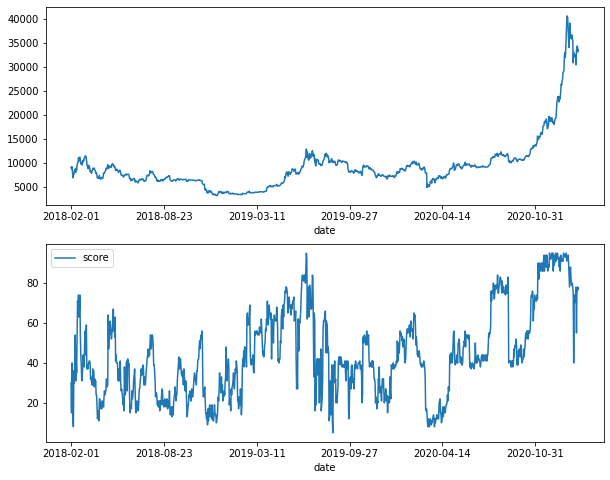

In [80]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
train_df['price'].plot(ax = ax[0])
train_df[['score']].plot(ax = ax[1])

## 1.3) AD Fuller Test

In [81]:
result_0 = adfuller(train_df['price'])
result_1 = adfuller(train_df['price'].diff(1).dropna())
result_2 = adfuller(train_df['price'].diff(1).diff(1).dropna())
print (f"diff = 0: p_value = {result_0[1]}")
print (f"diff = 1: p_value = {result_1[1]}")
print (f"diff = 2: p_value = {result_2[1]}")

diff = 0: p_value = 0.9988514116522154
diff = 1: p_value = 1.8228450263048648e-11
diff = 2: p_value = 1.2800492431905988e-21


## Facebook Profit (Final Model to deploy)

In [447]:
profet_df = prices_greed_df.reset_index()
profet_df.columns=['ds','y','score']

In [476]:
profet_train = profet_df.iloc[:1092]
profet_test = profet_df.iloc[1092:]

In [478]:
model = Prophet()
model.fit(profet_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [479]:
horizon = 30
future = model.make_future_dataframe(horizon)
forecast = model.predict(future)

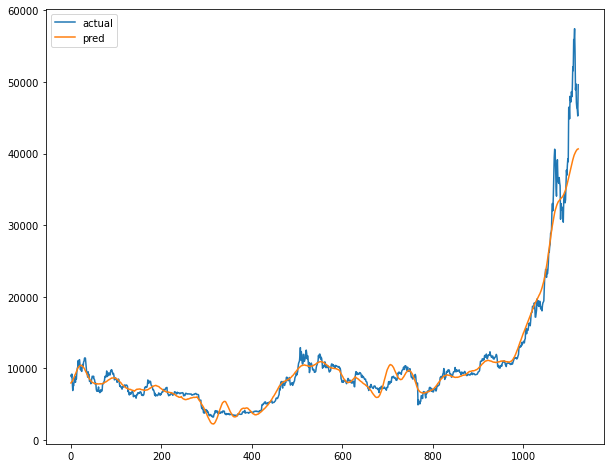

In [483]:
plt.figure(figsize=(10,8))
plt.plot(profet_df["y"], label="actual")
plt.plot(forecast["yhat"], label="pred")
plt.legend()

In [485]:
fg_model = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_prior_scale=2)
fg_model.add_regressor("score")
fg_model.fit(profet_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [486]:
horizon = 30
fg_model_future = fg_model.make_future_dataframe(horizon)
fg_model_future["score"] = profet_df["score"] 
fg_forecast = fg_model.predict(fg_model_future)

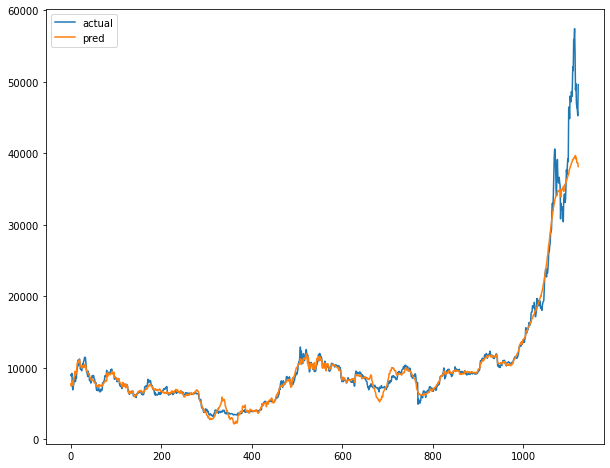

In [489]:
plt.figure(figsize=(10,8))
plt.plot(profet_df["y"], label="actual")
plt.plot(fg_forecast["yhat"], label="pred")
plt.legend()

## Sarimax Model 

### NOT SCALED

In [433]:
for date in pd.date_range('2021-02-01','2021-02-03'):
    d = date

In [440]:
pd.to_datetime(d)

Timestamp('2021-02-03 00:00:00', freq='D')

In [441]:
#for date in pd.date_range(pd.to_datetime('2021-02-01'),pd.to_datetime('2021-03-01')):
#        sarimax = SARIMAX(prices_greed_df.loc[:date]['price'], order=(p,1,q), exog=prices_greed_df.loc[:date]['price'])
#        results = sarimax.fit()
#        mae = abs(results.forecast(steps=1,exog=test_df['score'][0])[1094]-test_df['price'][0])
#        print(mae)

In [324]:
for i in range(pd.to_datetime('2021-02-01'),pd.to_datetime('2021-03-01'))
params = []
for p in range(6):
    for q in range(6):
        sarimax = SARIMAX(train_df['price'], order=(p,1,q), exog=train_df['score'])
        results = sarimax.fit()
        mae = abs(results.forecast(steps=1,exog=test_df['score'][0])[1094]-test_df['price'][0])
        params.append([f"p={p}, q={q}", results.aic, results.bic, mae])

In [319]:
results.forecast(steps=1,exog=test_df['score'][0])[1094]

33781.51673105629

In [294]:
sarimax = SARIMAX(train_df['price'], order=(1,1,1), exog=train_df['score'])
results = sarimax.fit()

In [295]:
results.mae

262.34621850323623

In [300]:
results.forecast(steps=1,exog=test_df['score'][0])

1094    33543.629282
dtype: float64

In [301]:
33543.629282-test_df['price'][0]

-1984.680717999996

In [226]:
#results.predict(dynamic=False,start=1094,end=1122)
preds = results.forecast(steps=28,exog=test_df['score'])

In [231]:
forecasts = pd.concat([train_df['price'],preds])

In [240]:
forecasts = pd.merge(pd.DataFrame(forecasts).reset_index(),prices_greed_df.reset_index(), left_index=True,right_index=True)

In [245]:
forecasts = forecasts.drop(columns=['index','price','score']).set_index('date')

In [265]:
sarimax = SARIMAX(train_df['price'], order=(5,1,1), exog=train_df['score'])
results = sarimax.fit()
results.forecast(steps=1,exog=test_df['score'][0])

1094    33635.47208
dtype: float64